In [1]:
import csv

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn import datasets
from tqdm.notebook import tqdm

torch.manual_seed(32)

In [2]:
f = True
X = []
y = []
with open(
    "../../data/diabetes1.csv",
    newline="",
) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if f:
            print(row)
            f = False
        X.append(np.array([float(row["Age"]), float(row["Glucose"])]))
        y.append(np.intc(1 if row["Outcome"].strip().upper() == "1" else 0))
X = np.array(X)
y = np.array(y)

x_data = torch.Tensor(X)
y_data = torch.Tensor(y.reshape(len(X), 1))

{'Pregnancies': '6', 'Glucose': '148', 'BloodPressure': '72', 'SkinThickness': '35', 'Insulin': '0', 'BMI': '33.6', 'DiabetesPedigreeFunction': '0.627', 'Age': '50', 'Outcome': '1'}


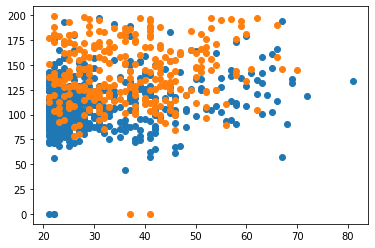

In [3]:
plt.scatter(X[y == 0, 0], X[y == 0, 1])
plt.scatter(X[y == 1, 0], X[y == 1, 1])

In [4]:
class Model(nn.Module):
    def __init__(self, input_size, layers, output_size):
        super().__init__()
        self.layers = []
        first = True
        for node_size in layers:
            if first:
                item = nn.Linear(input_size, layers[0])
                setattr(self, str(hash(item)), item)
                self.layers.append(item)
                previous_node_size = layers[0]
                first = False
                continue
            else:
                item = nn.Linear(previous_node_size, node_size)
                setattr(self, str(hash(item)), item)
                self.layers.append(item)
            previous_node_size = node_size
        item = nn.Linear(previous_node_size, output_size)
        setattr(self, str(hash(item)), item)
        self.layers.append(item)

    def forward(self, x):
        for layer in self.layers:
            x = torch.sigmoid(layer(x))
        return x

    def predict(self, x):
        pred = self.forward(x)
        if pred >= 0.5:
            return 1
        else:
            return 0

In [5]:
model = Model(2, [20, 20, 10], 1)
# print(list(model.parameters()))

In [6]:
model.layers

[Linear(in_features=2, out_features=20, bias=True),
 Linear(in_features=20, out_features=20, bias=True),
 Linear(in_features=20, out_features=10, bias=True),
 Linear(in_features=10, out_features=1, bias=True)]

In [7]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.5313, -0.3223],
         [-0.1215,  0.4041],
         [-0.5473,  0.1122],
         [ 0.2094, -0.6747],
         [ 0.1236, -0.2469],
         [ 0.6343,  0.0310],
         [ 0.5348,  0.3188],
         [ 0.2729, -0.6705],
         [ 0.6109, -0.5780],
         [ 0.3078,  0.3212],
         [-0.0046,  0.6092],
         [-0.1871, -0.4174],
         [ 0.2328, -0.1575],
         [-0.5959, -0.5025],
         [-0.4513,  0.2036],
         [-0.4944,  0.3225],
         [ 0.5469, -0.2869],
         [ 0.3999,  0.0148],
         [ 0.4507, -0.0892],
         [-0.4416,  0.5347]], requires_grad=True),
 Parameter containing:
 tensor([-0.4348,  0.1642,  0.4030, -0.5118, -0.6428,  0.3951, -0.6988, -0.5278,
          0.3065, -0.2371,  0.4991, -0.1528,  0.1138, -0.3906,  0.1398, -0.6531,
         -0.5377, -0.5433,  0.0832, -0.1256], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2226,  0.0084,  0.1928, -0.1329,  0.0555, -0.0384,  0.2026,  0.0746,
           0.0161,

In [8]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 4000
losses = []

progress_bar = tqdm(range(epochs))
for i in progress_bar:
    y_pred = model.forward(x_data)
    loss = criterion(y_pred, y_data)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    progress_bar.set_description(f"epoch: {i} loss: {loss.item()}")

  0%|          | 0/4000 [00:00<?, ?it/s]

Loss over time


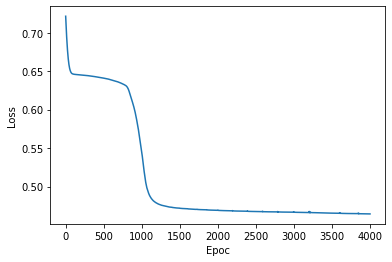

In [10]:
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoc")
print("Loss over time")

In [11]:
def plot_decision_boundry(X, y, scatter=False):
    x_span = np.linspace(min(X[:, 0]) - 0.25, max(X[:, 0] + 0.25))
    y_span = np.linspace(min(X[:, 1]) - 0.25, max(X[:, 1] + 0.25))
    xx, yy = np.meshgrid(x_span, y_span)
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    pred_func = model.forward(grid)
    z = pred_func.view(xx.shape).detach().numpy()
    plt.contourf(xx, yy, z)
    if scatter:
        plt.scatter(X[y == 0, 0], X[y == 0, 1])
        plt.scatter(X[y == 1, 0], X[y == 1, 1])

Trained Network


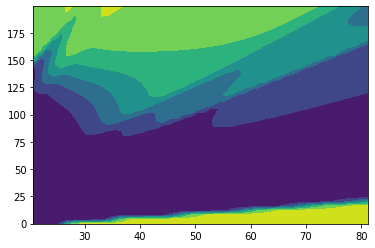

In [12]:
print("Trained Network")
plot_decision_boundry(X, y)

Trained Network With data


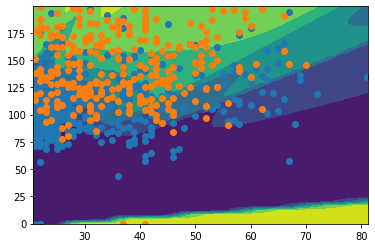

In [13]:
print("Trained Network With data")
plot_decision_boundry(X, y, scatter=True)

First Prediction, 33 years old with BGL 103, group 0 = No Diabetus
0


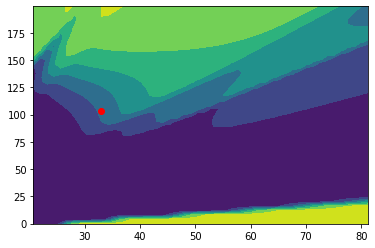

In [16]:
age = 33
bgl = 103
point = torch.Tensor([age, bgl])

pred = model.predict(point)
print("First Prediction, 33 years old with BGL 103, group 0 = No Diabetus")
print(pred)
plt.plot([age], [bgl], "or")
plot_decision_boundry(X, y)

Second Prediction, 45 Years old with BGL 120, group 1 = Possible Diabetus
1


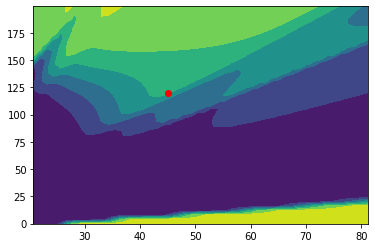

In [17]:
age = 45
bgl = 120
point = torch.Tensor([age, bgl])

pred = model.predict(point)
print("Second Prediction, 45 Years old with BGL 120, group 1 = Possible Diabetus")
print(pred)
plt.plot([age], [bgl], "or")
plot_decision_boundry(X, y)